# 🧗‍♂️ **IFSC Rock Climbing Performance Analysis**

### Final Project

**Author:** Derrick DeBuhr  
**Dataset:** IFSC Competition Results 1990–2019 (Kaggle)  
**Goal:** Explore international climbing competition data to understand performance trends, relationships between climber attributes and results, and prepare for predictive modeling.

## 📘 Project Overview

This notebook is the first milestone in a machine learning project exploring performance in international sport climbing competitions, using data from the **International Federation of Sport Climbing (IFSC)** spanning 1990–2019.

The dataset includes multiple Excel sheets containing:
- Competition results (for men, women, youth, and adults)
- Climber profiles (age, height, weight, nationality)
- Team and ranking information

**Objectives of this milestone:**
1. Load and inspect the IFSC dataset.
2. Perform basic exploratory data analysis (EDA).
3. Visualize key patterns in performance.
4. Prepare for later modeling stages (predicting performance outcomes).

This project aligns with my personal interest in rock climbing — the goal is to uncover what measurable factors contribute to performance across disciplines and time.


## ⚙️ 1. Setup

In this section, we import Python libraries for data manipulation, visualization, and analysis.  
We also configure general display settings to make the data easier to explore.


In [2]:
#Import core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='muted')

## 📂 2. Load the IFSC Dataset

The IFSC dataset is stored as a multi-sheet Excel file.  
We read it into Python using **pandas**, which allows us to explore each sheet (e.g., adult men’s results, climber profiles, rankings).

We'll start by inspecting the available sheets to get a sense of the structure and content.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonygiorgio/ifsc-climbing-competition-results-1991-2019")

print("Path to dataset files:", path)

100%|██████████| 7.27M/7.27M [00:00<00:00, 116MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/anthonygiorgio/ifsc-climbing-competition-results-1991-2019/versions/2


In [4]:
data_dir = "/root/.cache/kagglehub/datasets/anthonygiorgio/ifsc-climbing-competition-results-1991-2019/versions/2"
excel_path = os.path.join(data_dir, "IFSC Competiton Results 1990-2019 Dataset.xlsx")

data = pd.read_excel(excel_path, sheet_name=None)

# Display sheet names & shapes
print("Sheets loaded:")
for sheet, df in data.items():
    print(f"{sheet}: {df.shape}")


Sheets loaded:
Index: (25, 7)
AllCompetitions: (102249, 6)
1.Results.AllWorldChampionships: (9514, 9)
2.Climbers: (12824, 10)
3.Team Ranking: (116, 106)
4.Age Index: (56, 27)
5.Dependency Factor: (9604, 68)
RESULTS: (247, 109)
6.Results Only MEN: (5565, 8)
6.1. Adult M: (1469, 9)
6.2.Youth M: (4090, 8)
7. Results Only WOMEN: (3959, 8)
7.1.Adult W: (920, 9)
7.2.Youth W: (3036, 8)
LINK: (92, 12809)
DRAFT: (1702, 58)


In [5]:
# Extract adult datasets
adult_m = data["6.1. Adult M"]
adult_w = data["7.1.Adult W"]

print("Adult Men shape:", adult_m.shape)
print("\n\nAdult Women shape:", adult_w.shape)

Adult Men shape: (1469, 9)


Adult Women shape: (920, 9)


Clean data

In [6]:
# Function to clean adult competition data
def clean_adult_data(df):
    df = df.copy()

    # Convert age to numeric
    df['age (at time of competition)'] = pd.to_numeric(
        df['age (at time of competition)'], errors='coerce'
    )

    # Remove missing values
    df = df.dropna(subset=['age (at time of competition)', 'score'])

    # Keep reasonable age range
    df = df[(df['age (at time of competition)'] >= 15) &
            (df['age (at time of competition)'] <= 50)]

    return df

adult_m = clean_adult_data(adult_m)
adult_w = clean_adult_data(adult_w)

print("Adult Men shape:", adult_m.shape)
print("Adult Men Head: \n", adult_m.head())
print("\n\nAdult Women shape:", adult_w.shape)
print("Adult Women Head: \n", adult_w.head())

Adult Men shape: (1368, 9)
Adult Men Head: 
    year                               competition    category nation  \
1  1991  UIAA World Championship - Frankfurt 1991  M E N lead    AUS   
2  1991  UIAA World Championship - Frankfurt 1991  M E N lead    AUS   
3  1991  UIAA World Championship - Frankfurt 1991  M E N lead    AUT   
4  1991  UIAA World Championship - Frankfurt 1991  M E N lead    AUT   
5  1991  UIAA World Championship - Frankfurt 1991  M E N lead    AUT   

   climber ID   lastname firstname  score  age (at time of competition)  
1         347     Verick      Hira    0.0                          18.0  
2         546      Baker      Mark    0.0                          28.0  
3         811      Fürst    Stefan   26.0                          22.0  
4         344     Rieser    Hannes    1.0                          26.0  
5         454  Schwaiger     Josef    0.0                          20.0  


Adult Women shape: (850, 9)
Adult Women Head: 
    year                     

Let's make a scatterplot of the men and women:

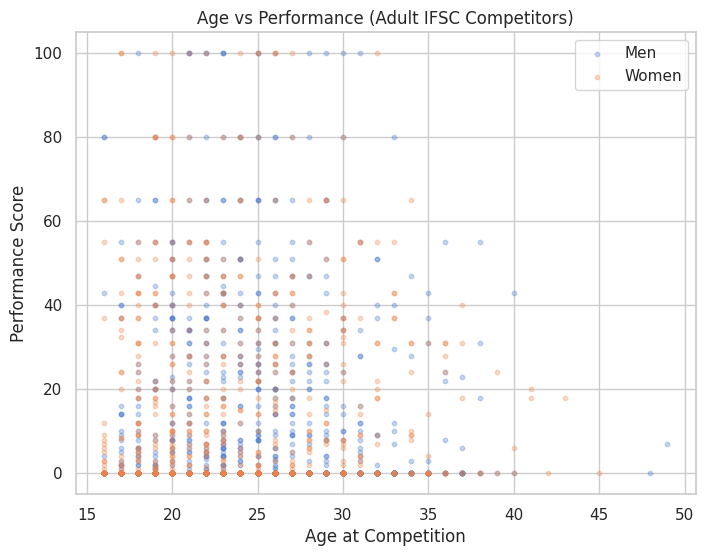

In [7]:
plt.figure(figsize=(8,6))

plt.scatter(
    adult_m['age (at time of competition)'],
    adult_m['score'],
    alpha=0.3,
    label="Men",
    s=10
)

plt.scatter(
    adult_w['age (at time of competition)'],
    adult_w['score'],
    alpha=0.3,
    label="Women",
    s=10
)

plt.xlabel("Age at Competition")
plt.ylabel("Performance Score")
plt.title("Age vs Performance (Adult IFSC Competitors)")
plt.legend()
plt.grid(True)
plt.show()


Let's add some regression lines to see if we can fit the data

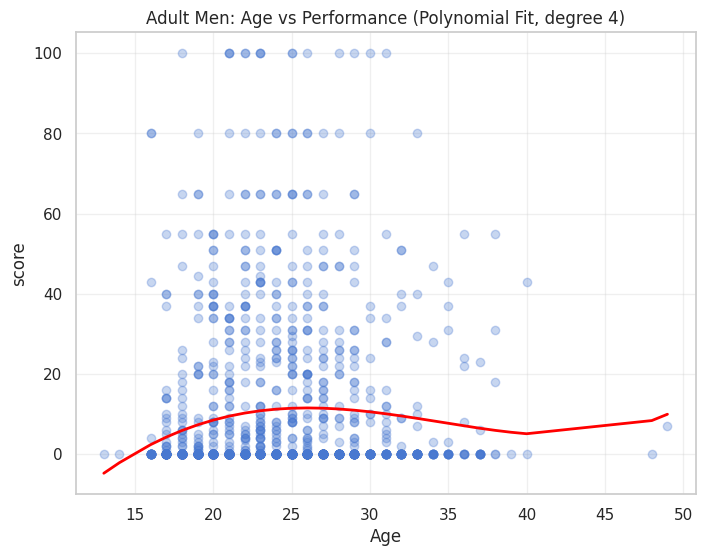

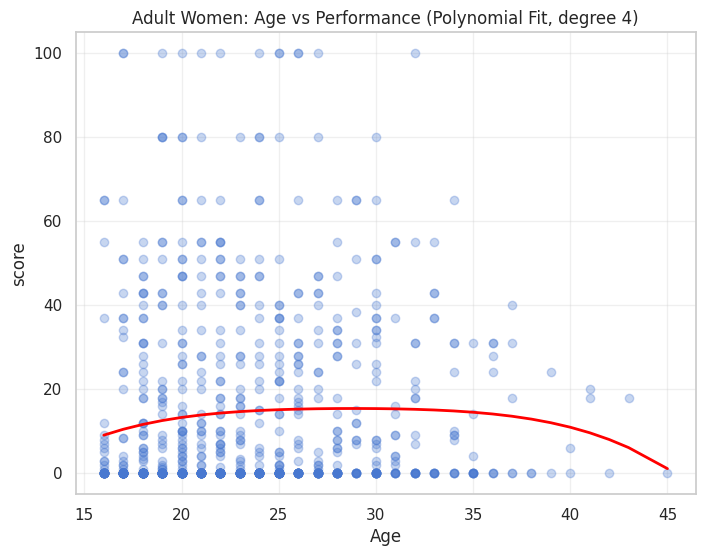

In [36]:
from sklearn.preprocessing import PolynomialFeatures

def plot_age_performance_poly(df, age_col, perf_col, title, degree=4):
    df = df[[age_col, perf_col]].dropna()

    X = df[age_col].values.reshape(-1,1)
    y = df[perf_col].values.reshape(-1,1)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    X_sorted = np.sort(X, axis=0)
    y_pred = model.predict(poly.transform(X_sorted))

    plt.figure(figsize=(8,6))
    plt.scatter(X, y, alpha=0.3)
    plt.plot(X_sorted, y_pred, color="red", linewidth=2)

    plt.xlabel("Age")
    plt.ylabel(perf_col)
    plt.title(f"{title} (Polynomial Fit, degree {degree})")
    plt.grid(alpha=0.3)

    plt.show()


plot_age_performance_poly(adult_m, "age (at time of competition)", "score", "Adult Men: Age vs Performance")
plot_age_performance_poly(adult_w, "age (at time of competition)", "score", "Adult Women: Age vs Performance")

### Interpretation of Results

This visualization shows how performance varies with age for adult climbers.

Key things to observe:
- The **peak performance age** for men and women
- Whether performance declines gradually or sharply with age
- Whether younger athletes are overrepresented or outperform older competitors

This analysis helps answer questions such as:
- At what age do climbers tend to perform best?
- Is professional climbing becoming dominated by younger athletes over time?
- Are men and women peaking at similar ages?


Let's try averaging the score to get a better idea of our data:

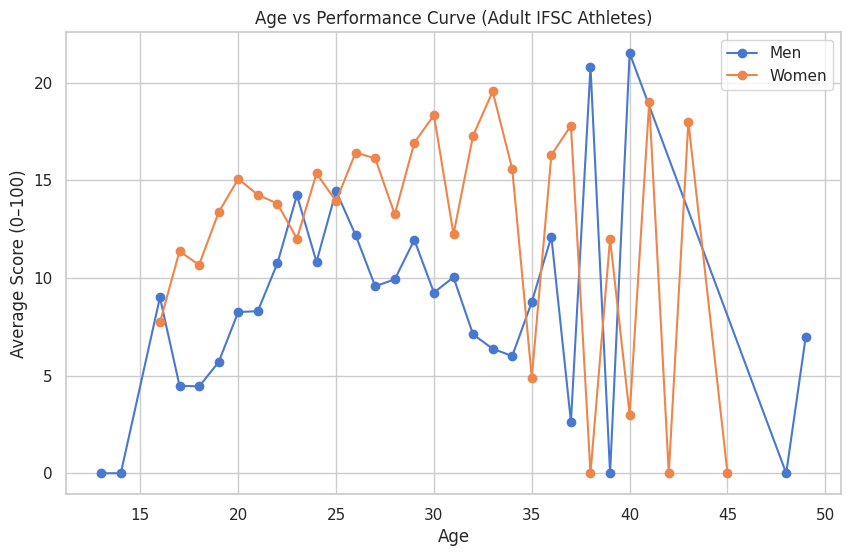

In [20]:
adult_m = data["6.1. Adult M"].copy()
adult_w = data["7.1.Adult W"].copy()

# Standardize age column
adult_m["age"] = pd.to_numeric(adult_m["age (at time of competition)"], errors="coerce")
adult_w["age"] = pd.to_numeric(adult_w["age (at time of competition)"], errors="coerce")

# Filter to valid rows
adult_m = adult_m.dropna(subset=["age", "score"])
adult_w = adult_w.dropna(subset=["age", "score"])

# Ensure numeric score
adult_m["score"] = pd.to_numeric(adult_m["score"], errors="coerce")
adult_w["score"] = pd.to_numeric(adult_w["score"], errors="coerce")

men_age_curve = (
    adult_m
    .groupby("age")["score"]
    .mean()
    .reset_index()
)

women_age_curve = (
    adult_w
    .groupby("age")["score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))

plt.plot(men_age_curve["age"], men_age_curve["score"],
         marker="o", label="Men")

plt.plot(women_age_curve["age"], women_age_curve["score"],
         marker="o", label="Women")

plt.xlabel("Age")
plt.ylabel("Average Score (0–100)")
plt.title("Age vs Performance Curve (Adult IFSC Athletes)")
plt.legend()
plt.grid(True)

plt.show()

Now let's add some regression lines to understand the data better:

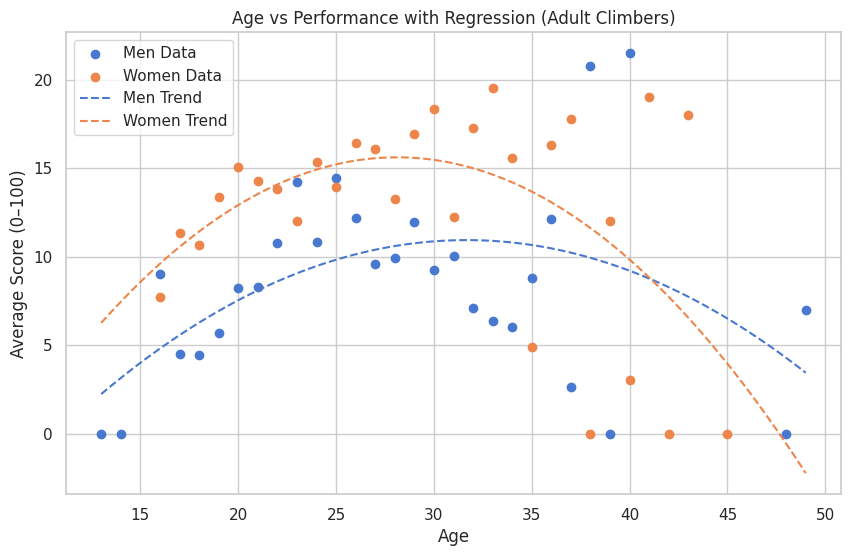

In [22]:
# Men's regression
men_coef = np.polyfit(men_age_curve["age"], men_age_curve["score"], 2)
men_poly = np.poly1d(men_coef)

# Women's regression
women_coef = np.polyfit(women_age_curve["age"], women_age_curve["score"], 2)
women_poly = np.poly1d(women_coef)

# Create smooth age range
age_range = np.linspace(
    min(men_age_curve["age"].min(), women_age_curve["age"].min()),
    max(men_age_curve["age"].max(), women_age_curve["age"].max()),
    100
)

plt.figure(figsize=(10,6))

# Original curves
plt.scatter(men_age_curve["age"], men_age_curve["score"], label="Men Data")
plt.scatter(women_age_curve["age"], women_age_curve["score"], label="Women Data")

# Regression lines
plt.plot(age_range, men_poly(age_range), linestyle="--", label="Men Trend")
plt.plot(age_range, women_poly(age_range), linestyle="--", label="Women Trend")

plt.xlabel("Age")
plt.ylabel("Average Score (0–100)")
plt.title("Age vs Performance with Regression (Adult Climbers)")
plt.legend()
plt.grid(True)

plt.show()


Now let's see if winners/competitors are getting younger

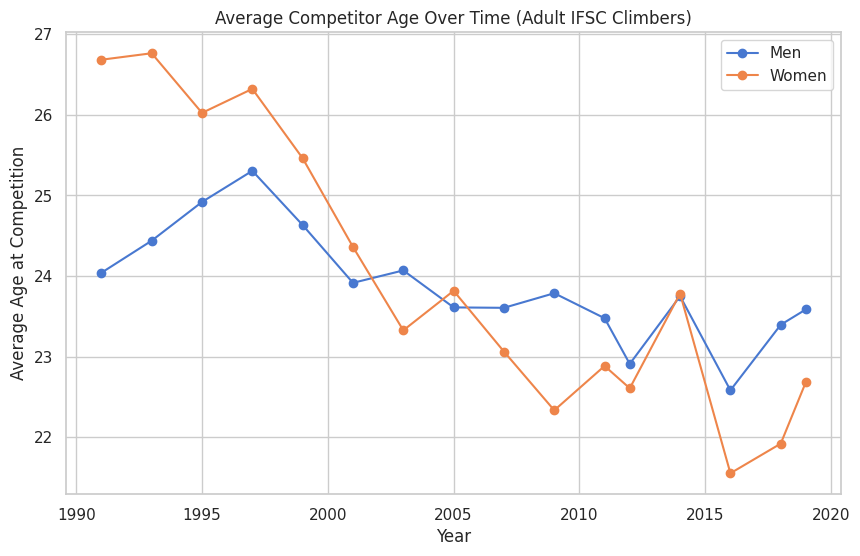

In [38]:
#Make a clean copy of the data
adult_m = data["6.1. Adult M"].copy()
adult_w = data["7.1.Adult W"].copy()

#Clean and standardize
adult_m["age"] = pd.to_numeric(adult_m["age (at time of competition)"], errors="coerce")
adult_w["age"] = pd.to_numeric(adult_w["age (at time of competition)"], errors="coerce")

adult_m = adult_m.dropna(subset=["age", "year"])
adult_w = adult_w.dropna(subset=["age", "year"])

#Compute average age per year
men_age_trend = (
    adult_m
    .groupby("year")["age"]
    .mean()
    .reset_index()
)
women_age_trend = (
    adult_w
    .groupby("year")["age"]
    .mean()
    .reset_index()
)

#Plot
plt.figure(figsize=(10,6))

plt.plot(men_age_trend["year"], men_age_trend["age"], marker="o", label="Men")
plt.plot(women_age_trend["year"], women_age_trend["age"], marker="o", label="Women")

plt.xlabel("Year")
plt.ylabel("Average Age at Competition")
plt.title("Average Competitor Age Over Time (Adult IFSC Climbers)")
plt.legend()
plt.grid(True)

plt.show()

Now let's add some regression to understand what is happening:

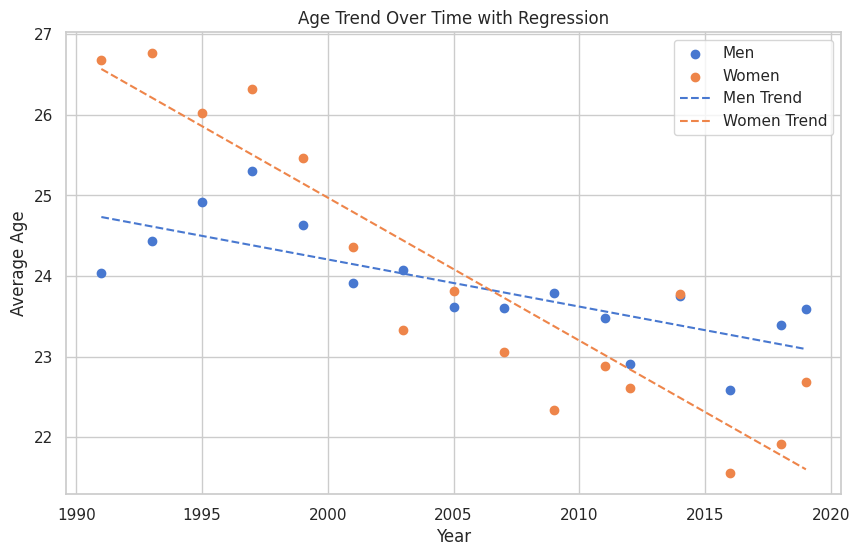

In [39]:
from numpy.polynomial.polynomial import polyfit

# Linear regression (easy to interpret)
b_men, m_men = polyfit(men_age_trend["year"], men_age_trend["age"], 1)
b_women, m_women = polyfit(women_age_trend["year"], women_age_trend["age"], 1)

years = np.array(men_age_trend["year"])

plt.figure(figsize=(10,6))

plt.scatter(men_age_trend["year"], men_age_trend["age"], label="Men")
plt.scatter(women_age_trend["year"], women_age_trend["age"], label="Women")

plt.plot(years, b_men + m_men*years, linestyle="--", label="Men Trend")
plt.plot(years, b_women + m_women*years, linestyle="--", label="Women Trend")

plt.xlabel("Year")
plt.ylabel("Average Age")
plt.title("Age Trend Over Time with Regression")
plt.legend()
plt.grid(True)

plt.show()


Interpretation:

In [40]:
print("Men age change per year:", round(m_men, 4), "years/year")
print("Women age change per year:", round(m_women, 4), "years/year")


Men age change per year: -0.0585 years/year
Women age change per year: -0.1775 years/year
